# Config

In [ ]:
# Libraries
from shapely import wkb
from shapely import from_wkb
import matplotlib.pyplot as plt

import geopandas as gpd
import duckdb
import duckdb
import geopandas as gpd

from config import INTERIM_DATA_DIR

# Load data

## Places

In [2]:
# 1️⃣ Connect + load extensions
duckdb.install_extension('httpfs')
duckdb.install_extension('spatial')
duckdb.load_extension('httpfs')
duckdb.load_extension('spatial')

# 2️⃣ S3 config
duckdb.sql("""
SET s3_region='us-west-2';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# 3️⃣ Bounding box
xmin, ymin = 2.10, 41.35
xmax, ymax = 2.25, 41.45
# 4️⃣ Query Overture "places"
query = f"""
SELECT
    id,
    names,
    categories,
    basic_category AS category,
    confidence,
    ST_AsWKB(geometry) AS geometry
  FROM read_parquet(
  's3://overturemaps-us-west-2/release/2025-10-22.0/theme=places/type=place/*.parquet'
)
WHERE geometry IS NOT NULL
  AND ST_Intersects(
      ST_GeomFromText('POLYGON(({xmin} {ymin}, {xmax} {ymin}, {xmax} {ymax}, {xmin} {ymax}, {xmin} {ymin}))'),
      geometry
  );
"""




In [3]:
# 5️⃣ Read into Pandas DataFrame
df = duckdb.sql(query).df()

In [4]:
# 6️⃣ Convert WKB geometry to Shapely
df["geometry"] = df["geometry"].apply(lambda x: wkb.loads(bytes(x)) if isinstance(x, (bytes, bytearray)) else None)

# 7️⃣ Wrap in GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 8️⃣ Inspect and plot
places = gdf.copy()
gdf.head()



,id,names,categories,category,confidence,geometry
0,911ab9de-4bf9-4804-9010-86b426d5189e,"{'primary': 'Beach Tennis Barcelona Club', 'co...","{'primary': 'gym', 'alternate': ['sports_and_r...",gym,0.618890,POINT (2.20971 41.39629)
1,413ca989-cdf4-4331-85bf-6760310876f1,"{'primary': 'Prime Training', 'common': None, ...","{'primary': 'fitness_trainer', 'alternate': None}",sport_fitness_facility,0.541414,POINT (2.21002 41.39577)
2,0b4fb796-3696-4cfa-9490-dd120afa080f,"{'primary': 'Playa Del Garraf', 'common': None...","{'primary': 'beach', 'alternate': ['hotel', 'b...",None,0.618890,POINT (2.20875 41.3953)
3,4d93a70a-4fe1-4e95-8b1e-d121bd02d9f9,"{'primary': 'Multiverse BeachVolley', 'common'...","{'primary': 'volleyball_club', 'alternate': ['...",sport_recreation_club,0.770000,POINT (2.20854 41.39575)
4,2efbcbfb-528f-4216-beb1-4a223c3fdfd0,{'primary': 'Phoenix Beach Volleyball Barcelon...,"{'primary': 'sports_club_and_league', 'alterna...",sport_recreation_club,0.982836,POINT (2.20867 41.39585)


# Data management (Code)

In [2]:
#Main body of code

# Plots

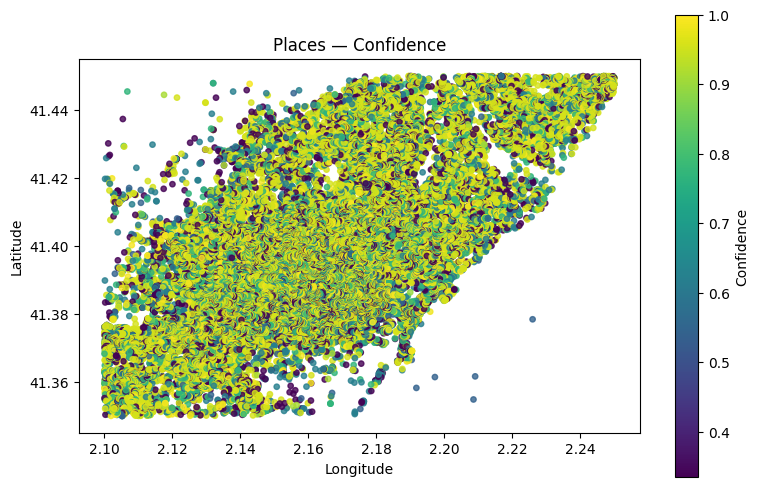

In [ ]:
# Plots and visualizations

fig, ax = plt.subplots(figsize=(8, 8))
places.plot(
    column="confidence",
    cmap="viridis",
    ax=ax,
    markersize=15,
    alpha=0.8,
    legend=True,
    legend_kwds={"label": "Confidence", "shrink": 0.6},
)
ax.set_title("Places — Confidence")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
plt.tight_layout()

# Save results

In [6]:
#Save results and figures
places.to_parquet(INTERIM_DATA_DIR / "overture_places.parquet")
places.to_file(INTERIM_DATA_DIR / "overture_places.geojson", driver="GeoJSON")